In [1]:
import math
import os
import random
import sys

from level_gen_sql import Tileset, AsciiLevel, SQLLevelSet

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector

<ipython-input-2-9dd2a69edd6c>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sm)


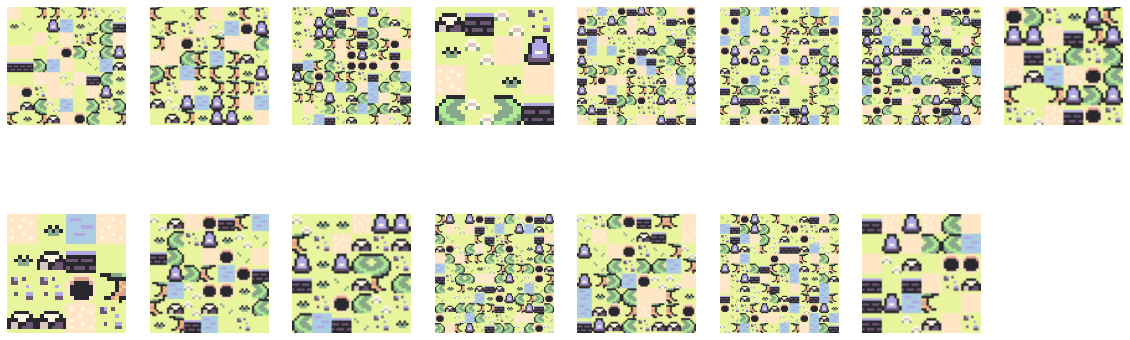

In [2]:
#show an ascii 2d map as an image
def showMap(m,tilename):
    t = Tileset(tilename)
    am = AsciiLevel(t,m.shape)
    am.importLevel(m)
    img = am.makeLevelImg()
    plt.imshow(img)
    plt.axis('off')
    
#show multiple maps in one cell
def showMultiMaps(ms,tilename,text='',textArr=None):
    t = Tileset(tilename)
    imgs = []
    #make an image for each map
    for m in ms:
        am = AsciiLevel(t,m.shape)
        am.importLevel(m)
        img = am.makeLevelImg()
        imgs.append(img)
        
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(imgs):
        plt.subplot(int(len(imgs) / col) + 1, col, i + 1)
        plt.imshow(im)
        plt.axis('off')
        if (textArr != None) and (i < len(textArr)):
            plt.title(textArr[i])
        
        if text != '':
            plt.suptitle(text)
            
#show random set of randomly generated maps
def makeRandomAscMaps(num_maps,map_size=None):
    sm = []
    for i in range(num_maps):
        if map_size == None:
            s = random.randint(4,12)
        else:
            s = map_size
        sm.append(np.random.randint(0, 16, size=(s, s)))
        
    return np.array(sm)
    
showMultiMaps(makeRandomAscMaps(random.randint(3,32)),random.choice(['pokemon','zelda','pacman','dungeon','amongus']))

In [3]:
zelda_tileset = Tileset("zelda")
pokemon_tileset = Tileset("pokemon")
pacman_tileset = Tileset("pacman")
amongus_tileset = Tileset("amongus")
dungeon_tileset = Tileset("dungeon")

In [4]:
# Tile-pattern Kullback-Leibler Divergence algorithm
# from Lucas and Volz https://arxiv.org/pdf/1905.05077.pdf

#create a the tile pattern probability dictionary from a level set
def getTPProb(levels,size=2):
    tpd = {}
    #get patterns from each level by using a sliding window (assume square level)
    for l in levels:
        for i in range(np.prod(l.shape)):
            c = i % l.shape[0]
            r = math.floor(i / l.shape[0])
            
            #check if out of bounds
            if((r+size)>l.shape[0] or (c+size)>l.shape[0]):
                continue
            
            #get the tile window set
            twin = l[r:r+size,c:c+size]
            twin_flat = "".join([hex(x).replace('0x','') for x in twin.flatten()])
            #twin_flat = str(twin.flatten())
            if twin_flat not in tpd:
                tpd[twin_flat] = 0
            tpd[twin_flat]+=1
    return tpd

#convert from string pattern to array pattern
def pat2Arr(p,WINDOW=2):
    return np.array([int(x,16) for x in p]).reshape(WINDOW,WINDOW)

#display the tile patterns and their frequencies
def showTilePat(tps,tilename,textArr):
    t = Tileset(tilename)
    imgs = []
    #make an image for each map
    for tp in tps:
        am = AsciiLevel(t,tp.shape)
        am.importLevel(tp)
        img = am.makeLevelImg()
        imgs.append(img)
        
    plt.figure(figsize=(20,5))
    col = 16
    for i, im in enumerate(imgs):
        plt.subplot(int(len(imgs) / col) + 1, col, i + 1)
        plt.imshow(im)
        plt.axis('off')
        if (textArr != None) and (i < len(textArr)):
            plt.title(textArr[i])

#C(x) = # tile patterns (x) | C = total # tile patterns
#P'(x)/Q'(x) formula = [C(x)+e]/[(C+e)(1+e)]
def probDist(cx,C):
    eps = 1e-6
    return (cx+eps)/((C+eps)*(1+eps))
            
#calculate the tile-pattern kl divergence fitness for a given map and given tile pattern dictionary
def tp_fitness(m,tpd):
    w = 0.5  #weight (symmetrical = 0.5)
    
    mtp = getTPProb([m])        #tile patterns for the input map
    N = sum(list(tpd.values())) #total # of tile patterns
    
    #DKL(P||Q) = sum[all tile pattern in set P => x](P'(x)log[P'(x)/Q'(x))]
    
    #input set in training set (p||q)
    dkl_p = 0
    for x in mtp.keys():
        #for each pattern in input set calculate and add value
        pcx = mtp[x] if x in mtp else 0
        qcx = tpd[x] if x in tpd else 0
        px = probDist(pcx,N)
        qx = probDist(qcx,N)

        dkl_p += px*math.log(px/qx)
            
    #training set in input set (q||p)
    dkl_q = 0
    for x in tpd.keys():
        #for each pattern in input set calculate and add value
        pcx = mtp[x] if x in mtp else 0
        qcx = tpd[x] if x in tpd else 0
        px = probDist(pcx,N)
        qx = probDist(qcx,N)

        dkl_q += qx*math.log(qx/px)
        
    print(f"P:{dkl_p} | Q:{dkl_q}")
    
    #calculate fitness
    #fitness = -[w*(DKL(P||Q)) + (1-w)*(DKL(Q||P))]
    return -(w*dkl_p + (1-w)*dkl_q)

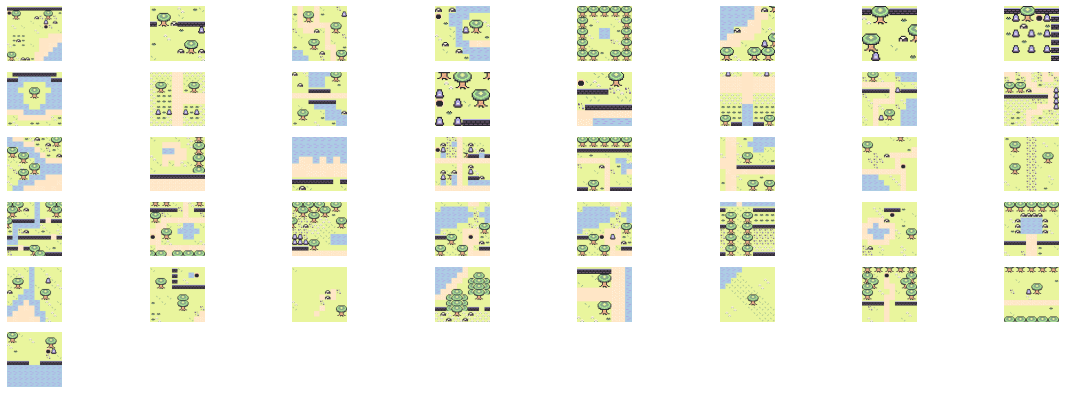

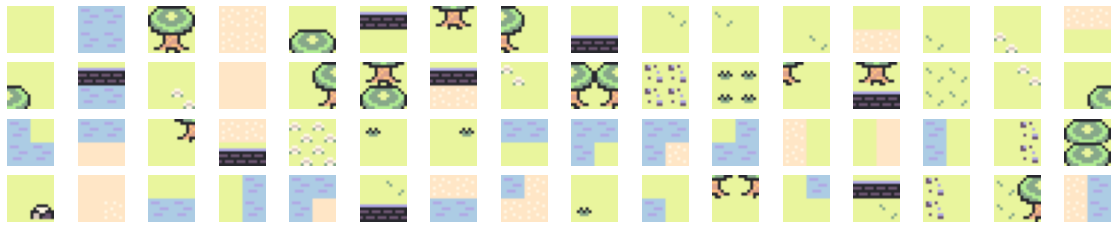

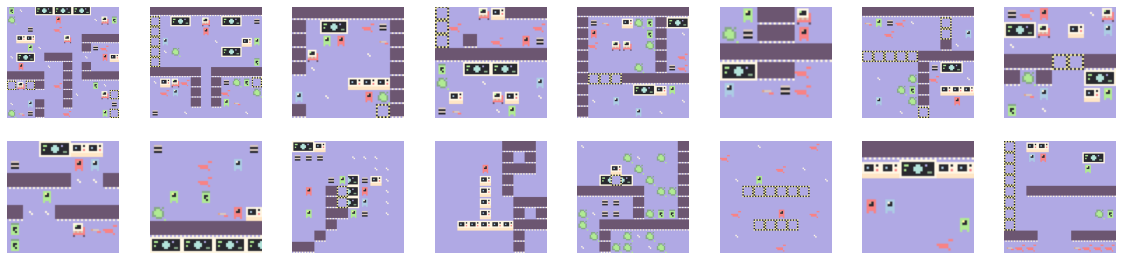

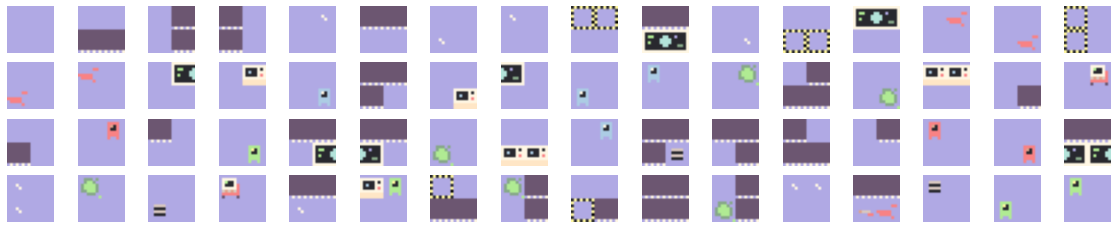

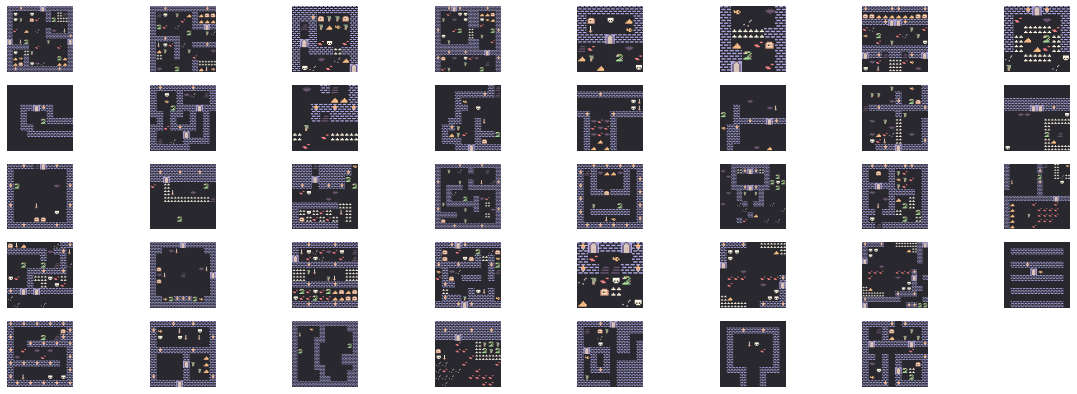

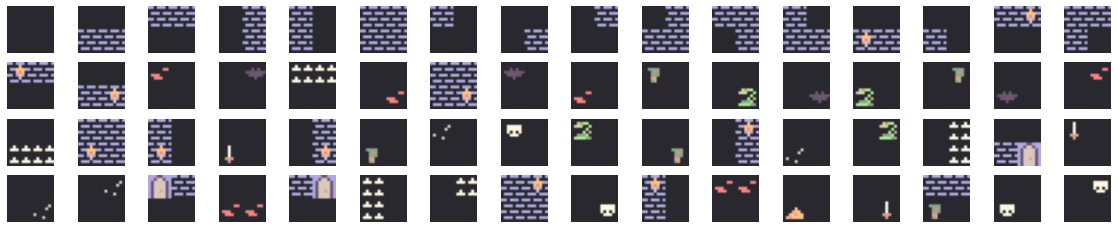

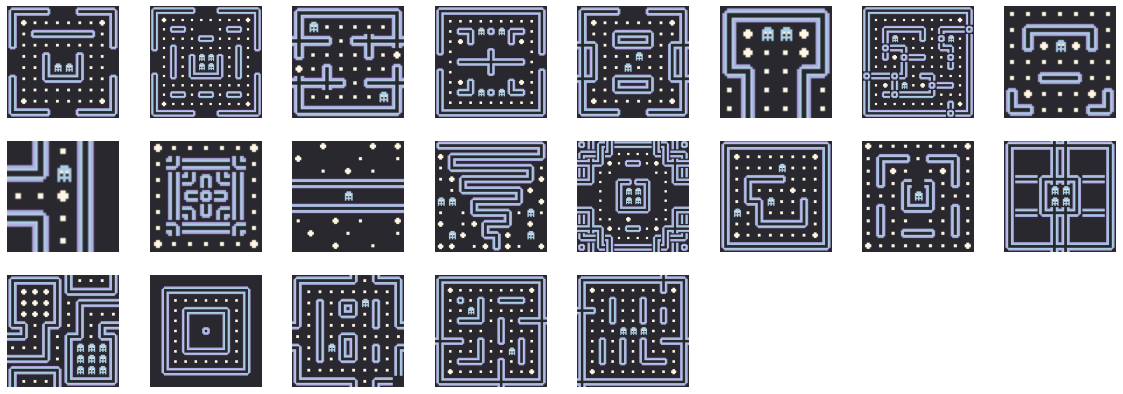

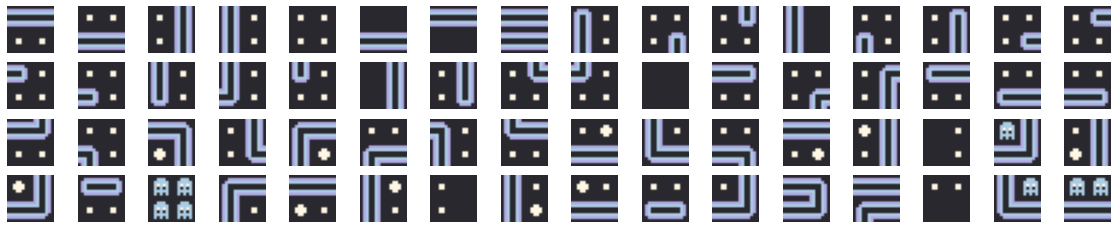

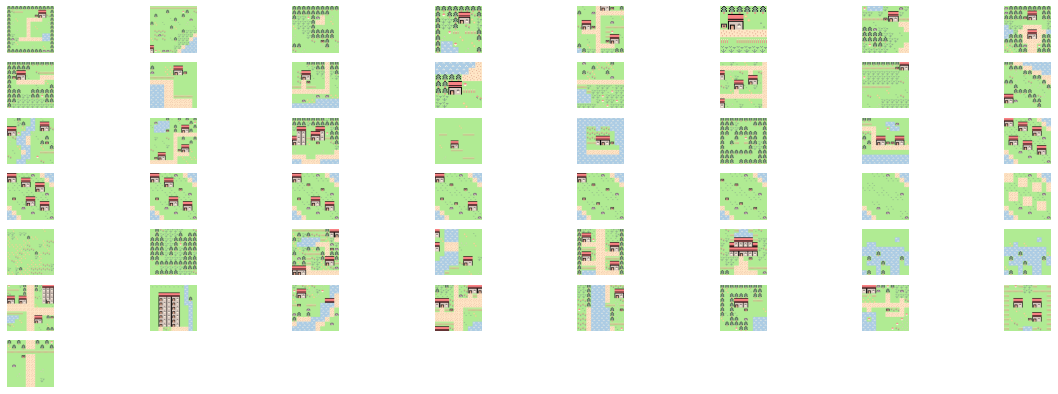

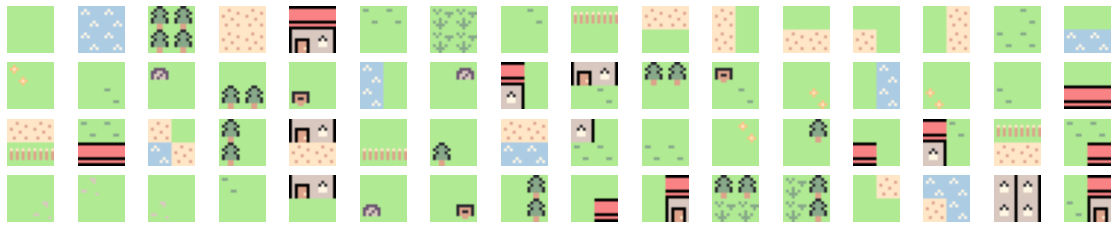

In [5]:
#get the training tile pattern dictionaries
tilesets = ["zelda","amongus", "dungeon", "pacman", "pokemon"]
tileset_tpdict = {}
tileset_train_maps = {}

for t in tilesets:
    TILENAME = t

    levelSet = SQLLevelSet("user",TILENAME).levelSet
    asc_levels = [l.ascii_level.level for l in levelSet]
    showMultiMaps(asc_levels,TILENAME)
    tileset_train_maps[TILENAME] = asc_levels

    #get tile patterns and display frequencies
    WINDOW = 2
    train_tp_set = {k:v for k,v in sorted(getTPProb(asc_levels,WINDOW).items(),reverse=True,key=lambda x:x[1])}

    #separate and display
    tps_arr = []
    tpf_arr = []
    for k,v in sorted(train_tp_set.items(), key=lambda x: x[1],reverse=True):
        #print(k)
        tps_arr.append(pat2Arr(k,WINDOW))
        tpf_arr.append(v)

    showTilePat(tps_arr[:64],TILENAME,None)
    #print(tpf_arr)
    
    tileset_tpdict[TILENAME] = train_tp_set

In [6]:
#calculate the tile-pattern kl divergence fitness for a given map and given tile pattern dictionary
def tp_fitness_REDO(m,tpd,WINDOW=2,SAMP_WEIGHT=0.5):
    w = SAMP_WEIGHT  #weight (symmetrical = 0.5)
    
    mtp = getTPProb([m],WINDOW)        #tile patterns for the input map
    P = sum(list(mtp.values()))
    Q = sum(list(tpd.values())) #total # of tile patterns
    
    
    print(mtp)
    
    #DKL(P||Q) = sum[all tile pattern in set P => x](P'(x)log[P'(x)/Q'(x))]
    
    #input set in training set (p||q)
    dkl_p = 0
    for x in mtp.keys():
        #for each pattern in input set calculate and add value
        pcx = mtp[x] if x in mtp else 0
        qcx = tpd[x] if x in tpd else 0
        px = probDist(pcx,P)
        qx = probDist(qcx,Q)

        dkl_p += px*math.log(px/qx)
            
    #training set in input set (q||p)
    dkl_q = 0
    for x in tpd.keys():
        #for each pattern in input set calculate and add value
        pcx = mtp[x] if x in mtp else 0
        qcx = tpd[x] if x in tpd else 0  
        px = probDist(pcx,P)
        qx = probDist(qcx,Q)

        dkl_q += qx*math.log(qx/px)
        
    print(f"P:{dkl_p} | Q:{dkl_q}")
    
    #calculate fitness
    #fitness = -[w*(DKL(P||Q)) + (1-w)*(DKL(Q||P))]
    return -(w*dkl_p + (1-w)*dkl_q)

{'998c': 1, '99cd': 2, '99d0': 2, '9900': 4, '990c': 1, '9903': 1, '8c0e': 1, 'cdef': 3, 'd0f0': 1, '0000': 11, '0007': 1, '0075': 1, '0c5e': 1, 'd0f5': 1, '0350': 1, '0e00': 1, 'ef00': 1, 'f000': 1, '0001': 5, '0710': 1, '7500': 1, '5e0a': 1, 'efa0': 1, 'f507': 1, '5070': 1, '0002': 2, '0020': 1, '0010': 2, '0100': 3, '1000': 3, '0a18': 1, 'a085': 1, '0750': 1, '7000': 1, '0200': 2, '2000': 2, '0120': 1, '1800': 1, '8500': 1, '5000': 1, '0003': 1, '0033': 2, '0030': 1, '0004': 3, '0044': 2, '0144': 1, '0303': 1, '3337': 1, '3373': 1, '3030': 2, '0444': 2, '4444': 3, '4446': 4, '0323': 1, '3730': 1, '7303': 1, '0404': 2, '4466': 1, '466b': 3, '2300': 1, '3000': 2, '0300': 1, '4646': 1, '666b': 1, '6bbb': 3, '00cd': 1, '00d0': 1, 'bbbb': 3, 'd0f2': 1, '0027': 1, '0077': 1, '0073': 1, '0434': 1}
P:0.9312253451802561 | Q:6.12840663293052
{'300c': 1, '00cd': 2, '00d0': 2, '0201': 1, '2010': 1, '0300': 2, '3100': 1, '0c9e': 1, 'cdef': 2, 'd0f7': 2, '0179': 1, '1099': 1, '0099': 2, '9e00': 1

{'b782': 1, '7721': 1, '7611': 2, '6011': 1, '0011': 1, '0411': 1, '4711': 2, '7712': 1, '7a28': 1, '8281': 1, '2114': 1, '1147': 2, '1177': 3, '1176': 2, '1261': 1, '2818': 1, '8151': 1, '1411': 1, '7711': 4, '6111': 1, '1815': 1, '5101': 1, '1111': 13, '1113': 1, '1130': 1, '1100': 2, '1103': 1, '1131': 1, '1510': 1, '0101': 1, '1318': 2, '308f': 1, '00ff': 1, '03f8': 1, '3181': 2, '1010': 1, '0131': 1, '181c': 1, '8fc7': 1, 'ff77': 1, 'f87d': 1, '81d1': 1, '1013': 1, '1c11': 1, 'c711': 1, '7d11': 1, 'd111': 1, '8182': 1, '1121': 1, '1112': 1, '1828': 1, '82c7': 1, '2177': 1, '1160': 1, '1104': 1, '1277': 1, '287d': 1}
P:0.8831665135482377 | Q:6.280113129274923
{'b782': 1, '7721': 1, '7711': 3, '7611': 1, '6011': 1, '0011': 1, '0411': 1, '4711': 1, '7712': 1, '7a28': 1, '8281': 1, '2114': 1, '1146': 5, '1161': 4, '1110': 1, '1100': 2, '1101': 1, '1114': 4, '1261': 1, '2818': 1, '8181': 4, '1411': 5, '4611': 6, '6111': 5, '1014': 1, '0046': 1, '0161': 1, '1818': 4, '8151': 3, '1113': 

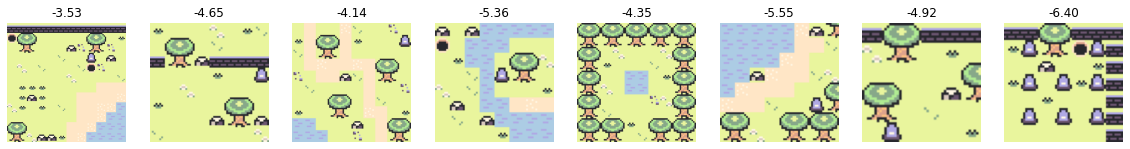

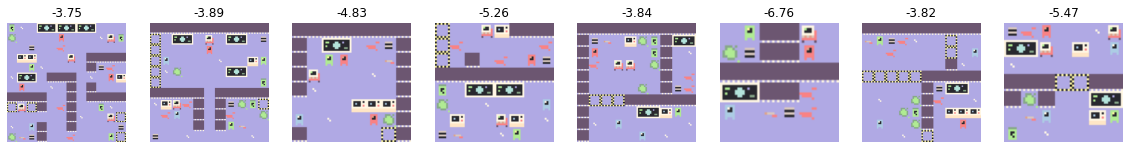

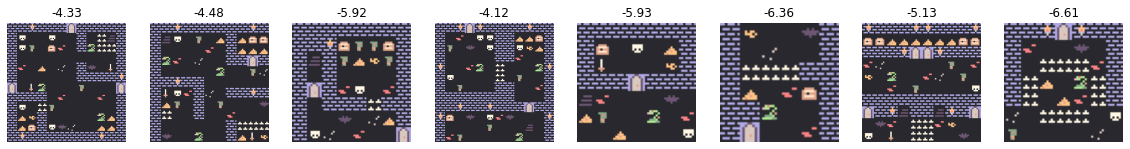

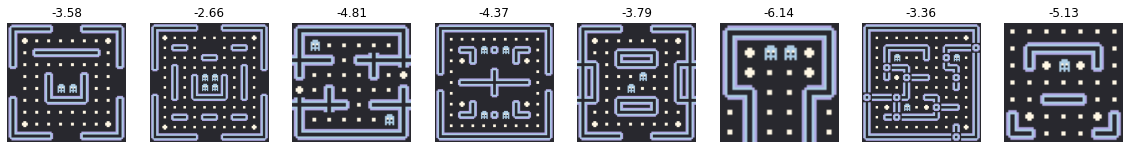

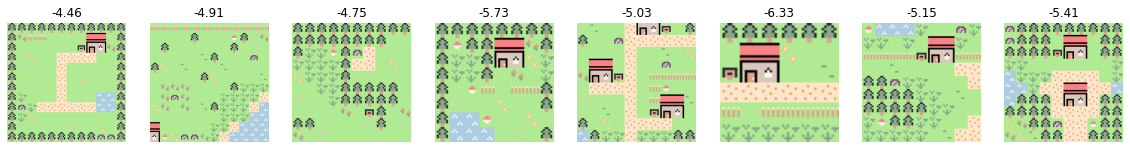

In [7]:
#test training on fitness (should be very small values for all since it is from the train data)
for t in tilesets:
    asc_maps = tileset_train_maps[t]
    f = []
    for m in asc_maps:
        f.append(f"{tp_fitness_REDO(m,tileset_tpdict[t]):.2f}")
    showMultiMaps(asc_maps,t,'',f)

<ipython-input-2-9dd2a69edd6c>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sm)


{'9dc7': 1, 'dd74': 1, 'd044': 1, '0c4b': 1, 'cdb2': 1, 'df2c': 1, 'fec5': 1, 'e659': 1, '689c': 1, 'c70d': 1, '74d3': 1, '4437': 1, '4b72': 1, 'b22b': 1, '2cb7': 1, 'c577': 1, '5973': 1, '9c3e': 1, '0d76': 1, 'd36e': 1, '37e0': 1, '7202': 1, '2b21': 1, 'b716': 1, '7765': 1, '7351': 1, '3e17': 1, '762c': 1, '6eca': 1, 'e0a8': 1, '028f': 1, '21f1': 1, '1610': 1, '650e': 1, '51ef': 1, '17f2': 1, '2cb6': 1, 'ca67': 1, 'a877': 1, '8f7d': 1, 'f1d7': 1, '1076': 1, '0e6e': 1, 'efea': 1, 'f2a4': 1, 'b650': 1, '670e': 1, '77e2': 1, '7d22': 1, 'd72a': 1, '76ac': 1, '6ec8': 1, 'ea81': 1, 'a419': 1, '502e': 1, '0ee7': 1, 'e270': 1, '2207': 1, '2a7c': 1, 'acce': 1, 'c8e3': 1, '8136': 1, '1961': 1, '2e7b': 1, 'e7b0': 1, '7008': 1, '0784': 1, '7c4b': 1, 'ceb7': 1, 'e371': 1, '361e': 1, '61e0': 1, '7b3a': 1, 'b0a9': 1, '089c': 1, '84ce': 1, '4bee': 1, 'b7e0': 1, '710b': 1, '1eb9': 1, 'e09c': 1}
P:15.617506327968098 | Q:13.128257350426784
{'a645': 1, '6955': 1, '9052': 1, '0b29': 1, 'b69f': 1, '63fc': 

{'9dc7': 1, 'dd74': 1, 'd044': 1, '0c4b': 1, 'cdb2': 1, 'df2c': 1, 'fec5': 1, 'e659': 1, '689c': 1, 'c70d': 1, '74d3': 1, '4437': 1, '4b72': 1, 'b22b': 1, '2cb7': 1, 'c577': 1, '5973': 1, '9c3e': 1, '0d76': 1, 'd36e': 1, '37e0': 1, '7202': 1, '2b21': 1, 'b716': 1, '7765': 1, '7351': 1, '3e17': 1, '762c': 1, '6eca': 1, 'e0a8': 1, '028f': 1, '21f1': 1, '1610': 1, '650e': 1, '51ef': 1, '17f2': 1, '2cb6': 1, 'ca67': 1, 'a877': 1, '8f7d': 1, 'f1d7': 1, '1076': 1, '0e6e': 1, 'efea': 1, 'f2a4': 1, 'b650': 1, '670e': 1, '77e2': 1, '7d22': 1, 'd72a': 1, '76ac': 1, '6ec8': 1, 'ea81': 1, 'a419': 1, '502e': 1, '0ee7': 1, 'e270': 1, '2207': 1, '2a7c': 1, 'acce': 1, 'c8e3': 1, '8136': 1, '1961': 1, '2e7b': 1, 'e7b0': 1, '7008': 1, '0784': 1, '7c4b': 1, 'ceb7': 1, 'e371': 1, '361e': 1, '61e0': 1, '7b3a': 1, 'b0a9': 1, '089c': 1, '84ce': 1, '4bee': 1, 'b7e0': 1, '710b': 1, '1eb9': 1, 'e09c': 1}
P:15.855608715590026 | Q:12.828373287568681
{'a645': 1, '6955': 1, '9052': 1, '0b29': 1, 'b69f': 1, '63fc': 

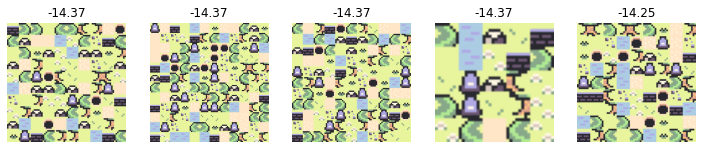

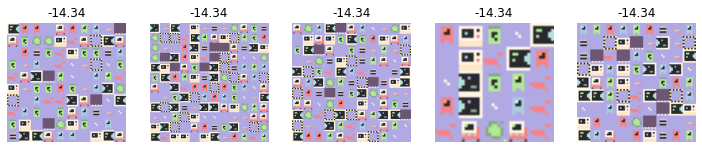

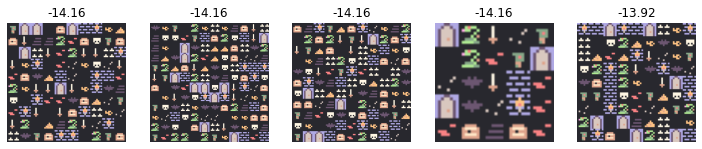

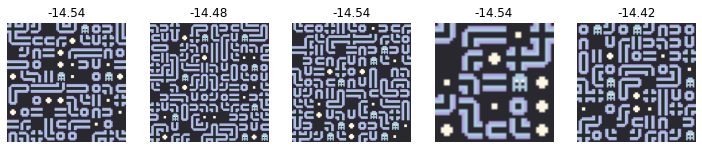

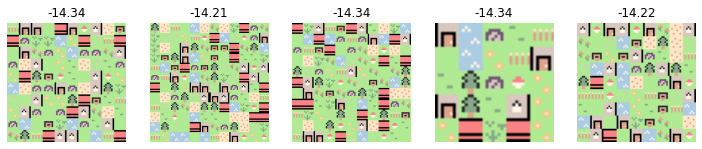

In [8]:
#test set
testMaps = makeRandomAscMaps(5) #use the same maps for each tileset

#calculate the tpkldiv fitness value for each map
for t in tilesets:
    f = []
    for m in testMaps:
        f.append(f"{tp_fitness_REDO(m,tileset_tpdict[t]):.2f}")
    showMultiMaps(testMaps,t,'',f)
    


In [9]:
m = np.array([
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [8, 12, 13, 0, 0, 0, 0, 0, 12, 13, 0, 3],
        [0, 14, 15, 0, 0, 0, 7, 5, 14, 15, 5, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 10, 0, 7, 0],
        [0, 2, 0, 1, 0, 0, 0, 1, 8, 5, 0, 0],
        [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1],
        [0, 3, 3, 3, 0, 0, 0, 0, 0, 4, 4, 4],
        [0, 3, 7, 3, 0, 0, 0, 4, 4, 4, 4, 6],
        [2, 3, 0, 3, 0, 1, 0, 4, 4, 6, 6, 11],
        [0, 0, 0, 0, 0, 0, 0, 4, 4, 6, 11, 11],
        [12, 13, 0, 0, 0, 0, 4, 4, 6, 11, 11, 11],
        [14, 15, 2, 7, 7, 3, 4, 6, 11, 11, 11, 11]
      ])
showMap(fake_map,'pokemon')
print(tp_fitness_REDO(fake_map,tileset_tpdict['pokemon']),0.1)
print(tp_fitness_REDO(fake_map,tileset_tpdict['pokemon']),0.5)
print(tp_fitness_REDO(fake_map,tileset_tpdict['pokemon']),0.9)

NameError: name 'fake_map' is not defined

In [ ]:
0.5*(4)+0.5*(10)

In [ ]:
import TPKLDiv as tpkl
user_tpd = tpkl.getTPProb(tileset_train_maps['pokemon'],2)
tpkl.tp_fitness(fake_map,user_tpd,WINDOW=2)

In [ ]:
m = np.array([
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [8, 12, 13, 0, 0, 0, 0, 0, 12, 13, 0, 3],
        [0, 14, 15, 0, 0, 0, 7, 5, 14, 15, 5, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 10, 0, 7, 0],
        [0, 2, 0, 1, 0, 0, 0, 1, 8, 5, 0, 0],
        [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1],
        [0, 3, 3, 3, 0, 0, 0, 0, 0, 4, 4, 4],
        [0, 3, 7, 3, 0, 0, 0, 4, 4, 4, 4, 6],
        [2, 3, 0, 3, 0, 1, 0, 4, 4, 6, 6, 11],
        [0, 0, 0, 0, 0, 0, 0, 4, 4, 6, 11, 11],
        [12, 13, 0, 0, 0, 0, 4, 4, 6, 11, 11, 11],
        [14, 15, 2, 7, 7, 3, 4, 6, 11, 11, 11, 11]
      ])
showMap(m,'pacman')
print(tpkl.tp_fitness(m,tileset_tpdict['pacman']))

---
## Other stuff

#### Entropy Test

In [37]:
#normal entropy function
def entropy(m):
    num_tiles = np.prod(m.shape)

    # get tile entropy #
    tileCts = {}
    for a in range(16):  #16 tiles
        tileCts[a] = 0

    for r in m:
        for t in r:
            tileCts[t]+=1

    tileProbs = {}
    for k,v in tileCts.items():
        tileProbs[k] = v/num_tiles
        
    print(tileProbs)

    return sum([-1*(p * math.log10(p)) for p in tileProbs.values() if p > 0])

{0: 0.4236111111111111, 1: 0.034722222222222224, 2: 0.027777777777777776, 3: 0.0625, 4: 0.09722222222222222, 5: 0.020833333333333332, 6: 0.041666666666666664, 7: 0.034722222222222224, 8: 0.013888888888888888, 9: 0.08333333333333333, 10: 0.006944444444444444, 11: 0.06944444444444445, 12: 0.020833333333333332, 13: 0.020833333333333332, 14: 0.020833333333333332, 15: 0.020833333333333332}
0.9200639067079279
{0: 0.1111111111111111, 1: 0.1111111111111111, 2: 0.05555555555555555, 3: 0.05555555555555555, 4: 0.0, 5: 0.1388888888888889, 6: 0.05555555555555555, 7: 0.0, 8: 0.05555555555555555, 9: 0.05555555555555555, 10: 0.1388888888888889, 11: 0.027777777777777776, 12: 0.08333333333333333, 13: 0.027777777777777776, 14: 0.05555555555555555, 15: 0.027777777777777776}
1.0882496205975472
{0: 0.5, 1: 0.0, 2: 0.0625, 3: 0.125, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0625, 11: 0.0, 12: 0.0625, 13: 0.0625, 14: 0.0625, 15: 0.0625}
0.7149462397019554


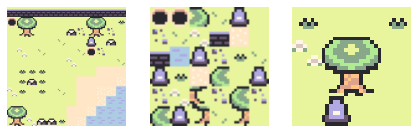

In [44]:
import utils
m1 = utils.makeRandomAscMaps(1)[0]
m2 = np.array([[3,0,0,3],[2,12,13,0],[0,14,15,0],[0,10,0,0]])
print(entropy(m))
print(entropy(m1))
print(entropy(m2))
showMultiMaps([m,m1,m2],"zelda")

In [39]:
print(len(np.unique(m)))
print(len(np.unique(m1)))

16
16


#### Aesthetic Bot banner (random tilemap generator)

In [117]:
all_tilesheets = [zelda_tileset,pokemon_tileset,amongus_tileset,pacman_tileset,dungeon_tileset]

#make a random tilemap with random tiles
def makeSuperRandomMapImg(full_tilesets,loc,pixel_size=(1200,400)):
    #setup the map
    p = 8
    mw = int(pixel_size[0]/p)
    mh = int(pixel_size[1]/p)
    print((mw,mh))
    #randMap = np.random.randint(0, 16, size=(mh, mw))
    
    #make the image
    superMap = Image.new("RGBA", pixel_size)
    i = 0
    for hi in range(mh):
        for wi in range(mw):
            tp = (wi*p,hi*p,(wi+1)*p,(hi+1)*p)

            #get the tile and place on image at position
            i += 1
            ss = full_tilesets[(i//16)%len(full_tilesets)].spritesheet
            tile = ss[randMap[hi][wi]]
            superMap.paste(tile,tp)

    #size up
#     biggerMap = superMap.resize(pixel_size,Image.NEAREST)
    superMap.save(loc)

In [118]:
makeSuperRandomMapImg(all_tilesheets,"twitter_banner.png")

(150, 50)


#### Animate population

In [167]:
import imageio
from tqdm import tqdm

# TURN POPULATION OF MAPS INTO A GIF
def animateMapPopulation(all_populations,tilename,outGif="population.gif"):
    t = Tileset(tilename)
    
    if not os.path.exists("_tmp/"):
        os.mkdir("_tmp/")

    #make a congregated image for each population set
    with tqdm(total=len(all_populations)) as pbar:
        for mi in range(len(all_populations)):
            ms = all_populations[mi]
            imgs = []
            #make an image for each map
            for m in ms:
                am = AsciiLevel(t,m.shape)
                am.importLevel(m)
                img = am.makeLevelImg()
                imgs.append(img)

            plt.figure(figsize=(20,7))
            
            col = 8
            for i, im in enumerate(imgs):
                plt.subplot(int(len(imgs) / col) + 1, col, i + 1)
                plt.axis('off')
                plt.imshow(im)
            plt.savefig(f"_tmp/{mi}.png")
            plt.close()
            
            pbar.update(1)
            
        
    #export the gif
    pop_imgs = []
    for i in range(len(all_populations)):
        pop_imgs.append(imageio.imread(f"_tmp/{i}.png"))
    imageio.mimsave(outGif, pop_imgs)
    
    #remove old files
    for i in range(len(all_populations)):
        os.remove(f"_tmp/{i}.png")
        
    

In [168]:
fake_pop = []
for i in range(10):
    fake_pop.append(makeRandomAscMaps(16))
    
animateMapPopulation(fake_pop,"pokemon")

<ipython-input-2-9dd2a69edd6c>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sm)
100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


<ipython-input-2-9dd2a69edd6c>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sm)


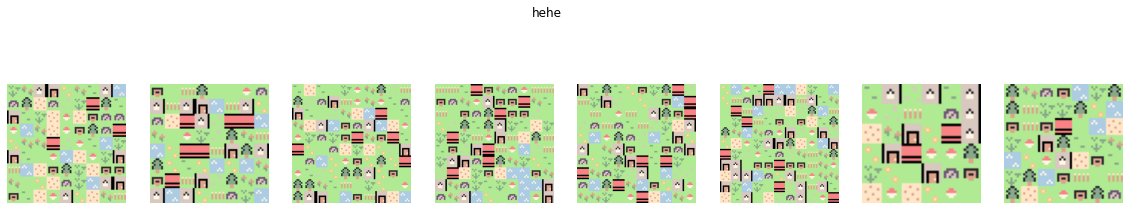

In [169]:
showMultiMaps(makeRandomAscMaps(8),"pokemon","hehe")

#### Show specific levels (for the paper)

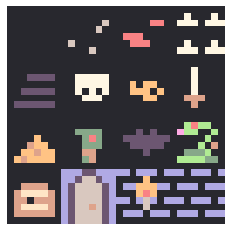

In [11]:
showMap(np.arange(16).reshape((4,4)),'dungeon')

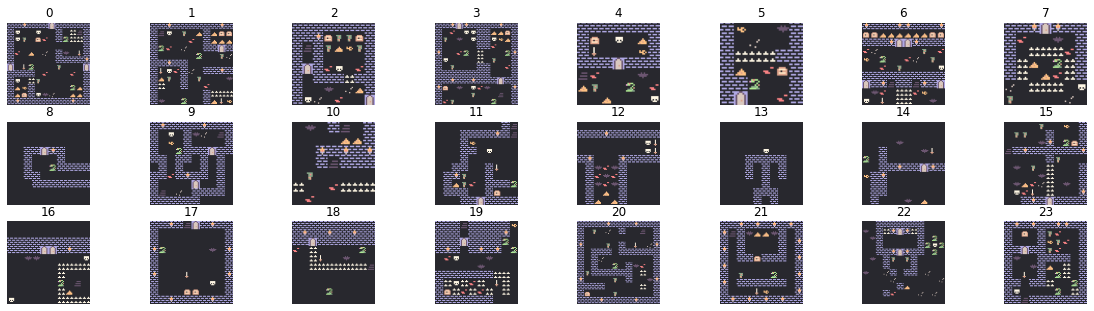

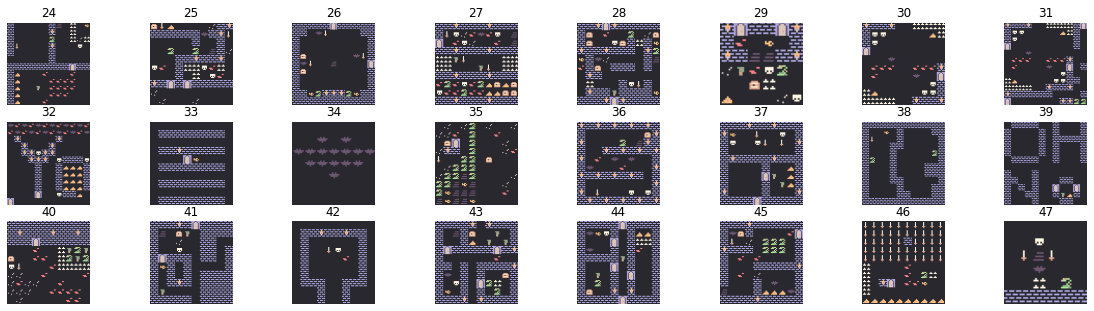

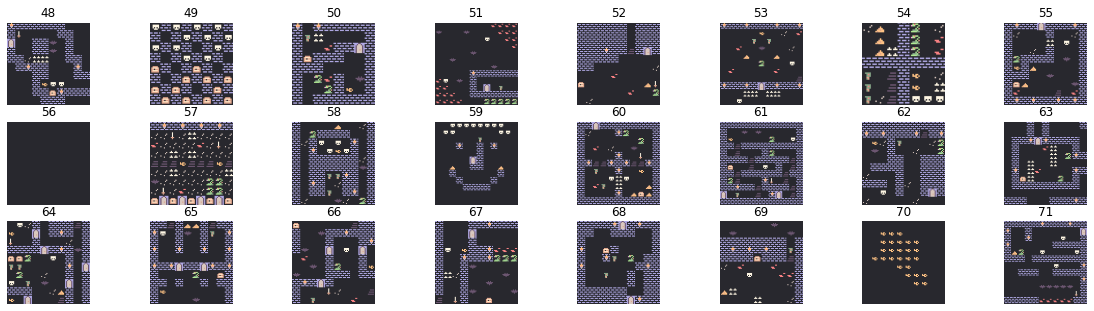

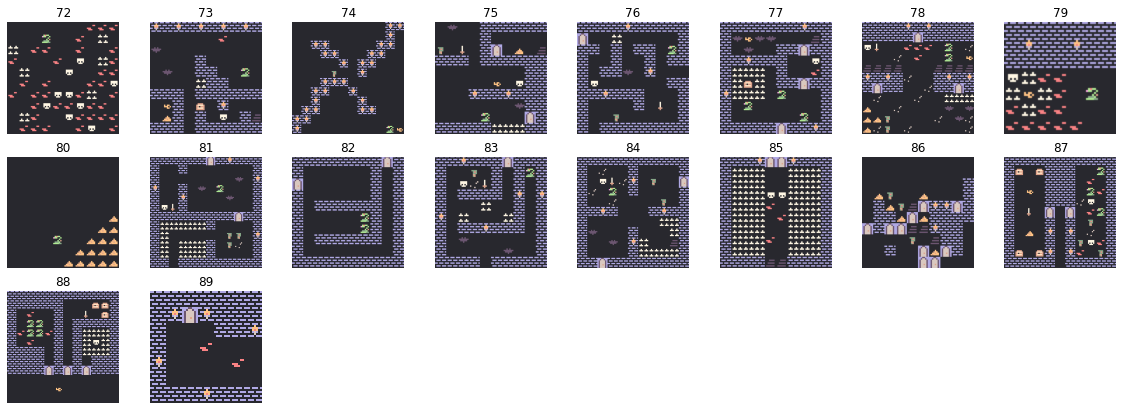

In [44]:
import utils
s = 24
T = "dungeon"
all_user_levels = utils.getAscUserLevels(T)
for i in range(0,len(all_user_levels),s):
    showMultiMaps(all_user_levels[i:i+s], T, '', list(range(i,i+s)))

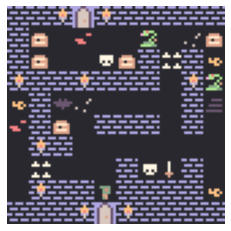

In [50]:
showMap(all_user_levels[28],T)

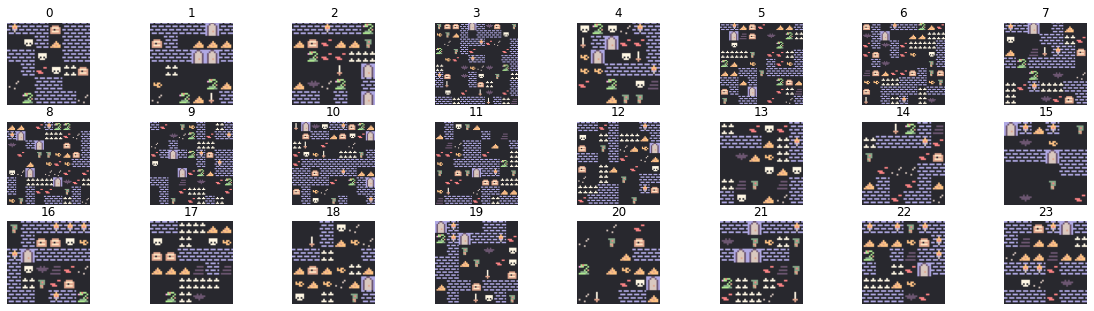

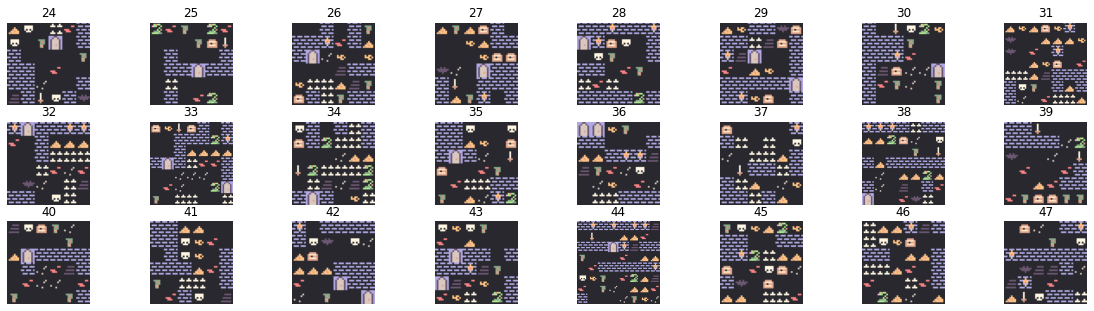

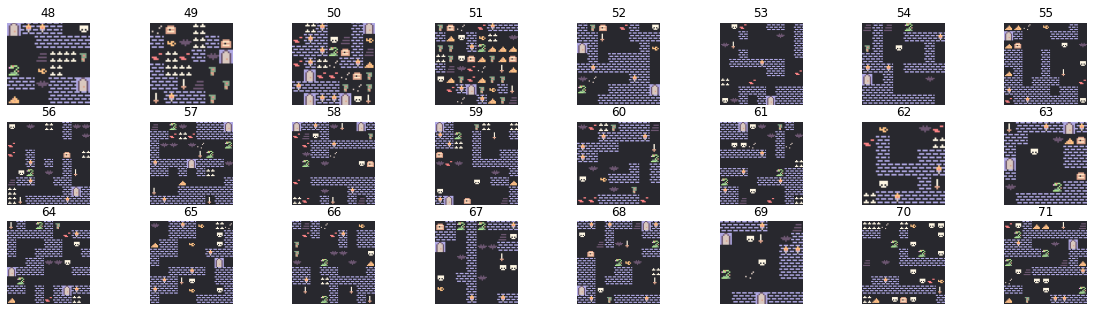

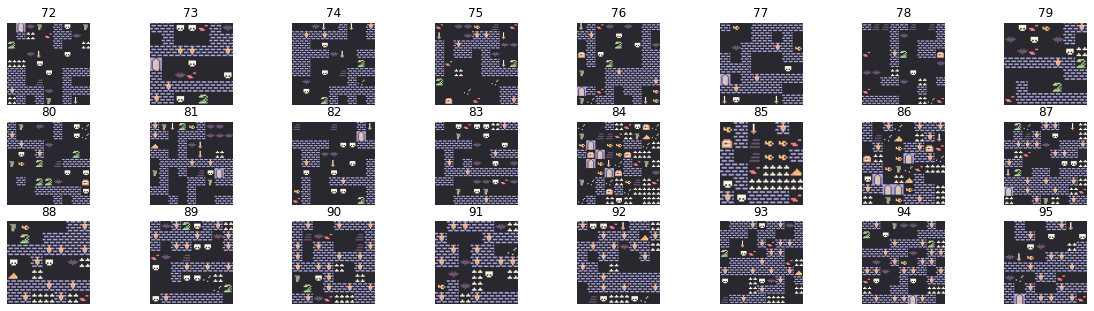

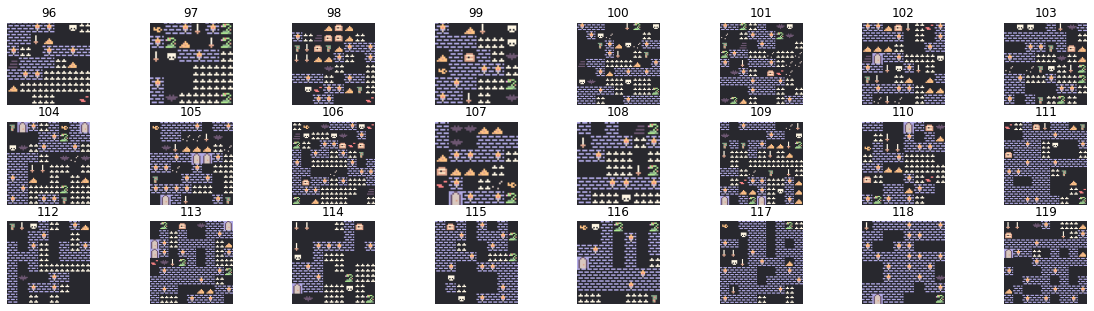

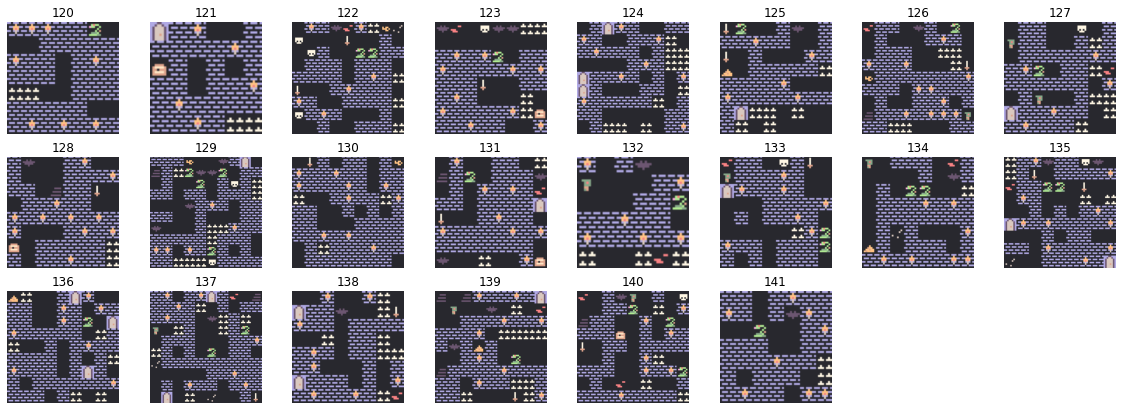

In [46]:
all_gen_levels = utils.getAscGenLevels(T)
s = 24
for i in range(0,len(all_gen_levels),s):
    showMultiMaps(all_gen_levels[i:i+s], T, '', list(range(i,i+s)))

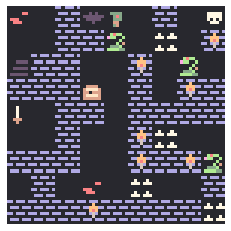

In [52]:
showMap(all_gen_levels[140],T)

#### Pairing growth over time (from http://localhost/~milk/aesthetic_stats.php)

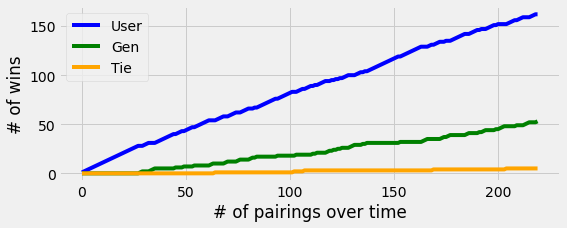

In [134]:
user_wins = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,28,28,29,30,31,31,31,31,32,33,34,35,36,37,38,39,40,40,41,42,43,43,44,45,46,47,47,48,49,50,51,52,53,54,54,54,54,55,56,57,58,58,58,59,60,61,62,62,62,63,64,65,66,66,66,67,67,68,69,70,71,72,73,74,75,76,76,77,78,79,80,81,82,83,83,83,84,85,86,86,87,88,89,89,90,90,91,92,93,94,94,94,95,95,96,96,97,97,98,99,100,100,100,100,101,102,103,103,104,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,119,120,121,122,123,124,125,126,127,128,129,129,129,129,130,131,131,132,133,134,134,134,135,135,135,136,137,138,139,140,141,142,142,142,143,144,145,146,146,147,147,147,148,149,150,151,151,152,152,152,152,152,153,154,155,156,156,157,158,159,159,159,159,160,161,162,162]
gen_wins = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,3,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,7,7,7,7,7,8,8,8,8,8,8,8,8,9,10,10,10,10,10,10,11,12,12,12,12,12,13,14,14,14,14,14,15,16,16,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,19,19,19,19,19,19,19,19,20,20,21,21,21,21,21,22,23,23,24,24,25,25,26,26,26,26,27,28,29,29,29,29,30,30,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,32,32,32,32,32,32,32,32,32,32,32,33,34,35,35,35,35,35,35,35,36,37,37,38,39,39,39,39,39,39,39,39,40,41,41,41,41,41,42,42,43,44,44,44,44,44,45,45,46,47,48,48,48,48,48,48,49,49,49,49,50,51,52,52,52,52,53]
tie_wins = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]

plt.figure(figsize=(8,3))
plt.plot(user_wins,label='User',color='b')
plt.plot(gen_wins,label='Gen',color='g')
plt.plot(tie_wins,label='Tie',color='orange')
# plt.hist(user_wins,bins=5)
plt.ylabel('# of wins')
plt.xlabel('# of pairings over time')
plt.legend()
plt.show()

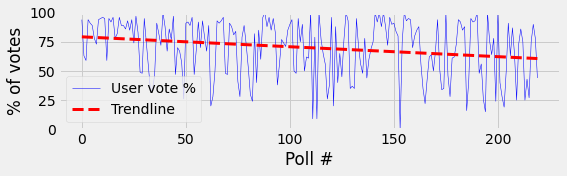

In [164]:
user_perc_wins = [0.94,0.63,0.59,0.94,0.91,0.89,0.78,0.73,0.94,0.95,0.96,0.95,0.59,0.95,0.92,0.96,0.78,0.82,0.96,0.89,0.89,0.86,0.93,0.85,0.94,0.74,0.97,0.83,0.49,0.48,0.95,0.74,0.53,0.33,0.34,0.47,0.91,0.82,0.72,1.00,0.88,0.67,0.86,0.77,0.97,0.47,0.70,0.67,0.58,0.26,0.91,0.92,0.89,0.96,0.47,0.68,0.92,0.70,0.93,0.79,0.67,0.89,0.20,0.29,0.50,0.93,0.91,0.93,0.96,0.48,0.47,0.91,0.88,0.81,0.84,0.41,0.29,0.79,0.89,0.73,0.53,0.30,0.24,0.82,0.40,0.85,0.60,0.96,1.00,0.88,0.96,0.85,0.95,0.83,0.38,0.56,0.77,0.74,0.71,0.85,0.90,0.94,0.50,0.48,0.95,0.75,0.90,0.50,0.62,0.61,1.00,0.09,0.79,0.09,1.00,0.77,0.65,0.56,0.26,0.38,0.96,0.20,0.88,0.40,0.65,0.45,0.77,1.00,0.93,0.35,0.37,0.35,0.95,0.71,0.57,0.48,0.78,0.44,0.60,0.69,0.75,1.00,0.92,1.00,0.88,1.00,0.88,0.72,0.96,0.90,0.91,0.84,0.80,0.00,0.75,1.00,0.93,0.95,0.94,0.70,0.80,0.85,0.88,0.57,0.35,0.22,0.43,0.62,0.64,0.50,0.67,0.94,0.52,0.34,0.35,1.00,0.46,0.29,0.61,0.62,0.73,0.94,0.92,0.85,0.88,0.16,0.42,0.95,0.92,0.93,1.00,0.48,0.57,0.26,0.15,1.00,0.76,0.64,0.78,0.24,1.00,0.40,0.29,0.19,0.50,0.91,0.63,0.87,0.64,0.25,0.73,0.86,0.75,0.25,0.43,0.27,0.75,0.90,0.78,0.44]
user_perc_wins2 = [int(x*100) for x in user_perc_wins]
gen_perc_wins = [1-x for x in user_perc_wins]

#calc trend line
x = range(len(user_perc_wins2))
z = np.polyfit(x, user_perc_wins2, 1)
p = np.poly1d(z)


plt.figure(figsize=(8,2))
plt.plot(user_perc_wins2, label='User vote %', linewidth=0.5, color='blue')
#plt.plot(gen_perc_wins, label='Gen', color='green')
plt.plot(x, p(x), label='Trendline',color='red', linewidth=3, linestyle="--")

plt.xlabel("Poll #")
plt.ylabel("% of votes")
plt.ylim(0,100)
plt.legend()
plt.show()




In [1]:
votes = [18,38,51,160,78,95,76,56,82,42,46,40,34,91,48,45,41,34,45,36,36,35,43,33,32,42,36,29,49,58,39,39,40,43,29,30,33,34,39,31,34,24,36,30,32,30,27,30,31,27,33,25,35,25,17,28,25,23,30,24,24,19,15,28,26,28,33,29,27,27,32,35,32,16,25,29,41,24,18,22,17,27,33,33,25,26,20,23,21,24,25,27,19,18,21,16,26,23,17,20,21,17,20,21,19,20,20,26,29,18,16,23,19,22,23,22,17,18,19,24,28,20,26,10,23,20,30,10,15,17,19,17,20,14,21,21,23,18,25,26,24,105,13,19,26,24,17,25,24,31,23,25,20,25,12,17,30,20,18,20,20,20,16,21,17,23,23,21,28,16,30,16,23,32,23,18,13,17,18,26,22,16,12,20,24,25,26,20,13,14,15,25,21,23,20,21,21,25,18,17,25,15,24,16,16,22,8,46,22,16,22,21,20,28,23,11,40,20,23,18]
plt.figure(figsize=(8,2))
plt.plot(votes, color='orange',label='Votes on poll',linewidth=2)
plt.ylabel('# of votes')
plt.xlabel('Poll #')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

[[28, 2, 0], [24, 6, 0], [20, 9, 1], [22, 6, 2], [22, 8, 0], [21, 8, 1], [19, 10, 1], [6, 4, 0]]
[[28 24 20 22 22 21 19  6]
 [ 2  6  9  6  8  8 10  4]
 [ 0  0  1  2  0  1  1  0]]


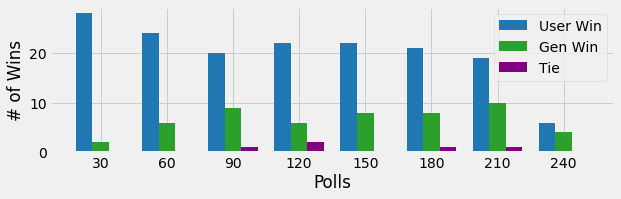

In [152]:
U = 1
G = 2
T = 3
SPLIT = 30
win_dist = [U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,G,G,U,U,U,G,G,G,U,U,U,U,U,U,U,U,U,G,U,U,U,G,U,U,U,U,G,U,U,U,U,U,U,U,G,G,T,U,U,U,U,G,G,U,U,U,U,G,G,U,U,U,U,G,G,U,G,U,U,U,U,U,U,U,U,U,G,U,U,U,U,U,U,U,T,G,U,U,U,T,U,U,U,G,U,G,U,U,U,U,G,G,U,G,U,G,U,G,U,U,U,G,G,G,U,U,U,G,U,G,U,U,U,U,U,U,U,U,U,U,U,U,U,U,U,G,U,U,U,U,U,U,U,U,U,U,G,G,G,U,U,T,U,U,U,G,G,U,G,G,U,U,U,U,U,U,U,G,G,U,U,U,U,G,U,G,G,U,U,U,U,G,U,G,G,G,T,U,U,U,U,G,U,U,U,G,G,G,U,U,U,G]
win_sec = np.split(win_dist,np.arange(SPLIT,len(win_dist),SPLIT))
win_cts = []
for s in win_sec:
    #win_cts.append({"user":list(s).count(U),"gen":list(s).count(G),"tie":list(s).count(T)})
    win_cts.append([list(s).count(U),list(s).count(G),list(s).count(T)])
print(win_cts)
win_cts_T = np.array(win_cts).transpose()
print(win_cts_T)

X = np.array(range(0,len(win_dist),SPLIT))+SPLIT
X_axis = np.arange(len(X))
colors = ["tab:blue","tab:green","purple"]
W = 0.25
labels = ["User Win","Gen Win","Tie"]
off = [-1,0,1]
plt.figure(figsize=(9,2.5))
for i in range(len(win_cts_T)):
    plt.bar(X_axis+off[i]*W,win_cts_T[i],width=W, color=colors[i],align='center',label=labels[i])
plt.xticks(X_axis,X)
plt.legend()
plt.xlabel("Polls")
plt.ylabel("# of Wins")
plt.show()

#### Training on paur data and separation

In [2]:
import utils

s = utils.getPairTrainData(10)
print(s['maps']['zelda'])

** Not enough votes for ID [ 53 ] (1 < 10)
** Not enough votes for ID [ 55 ] (1 < 10)
** Not enough votes for ID [ 56 ] (1 < 10)
** Not enough votes for ID [ 57 ] (1 < 10)
** Not enough votes for ID [ 58 ] (0 < 10)
** Not enough votes for ID [ 70 ] (1 < 10)
** Not enough votes for ID [ 71 ] (1 < 10)
** Not enough votes for ID [ 72 ] (0 < 10)
** Not enough votes for ID [ 74 ] (0 < 10)
** Not enough votes for ID [ 76 ] (1 < 10)
** Not enough votes for ID [ 77 ] (0 < 10)
** Not enough votes for ID [ 78 ] (0 < 10)
** Not enough votes for ID [ 79 ] (0 < 10)
** Not enough votes for ID [ 80 ] (0 < 10)
** Not enough votes for ID [ 81 ] (1 < 10)
** Not enough votes for ID [ 82 ] (0 < 10)
** Not enough votes for ID [ 83 ] (0 < 10)
** Not enough votes for ID [ 84 ] (0 < 10)
** Not enough votes for ID [ 85 ] (1 < 10)
** Not enough votes for ID [ 86 ] (0 < 10)
** Not enough votes for ID [ 87 ] (1 < 10)
** Not enough votes for ID [ 90 ] (0 < 10)
** Not enough votes for ID [ 91 ] (0 < 10)
** Not enou

In [8]:
import pair_gen_sql

sorted_gen_levels = pair_gen_sql.getUnevalLevels("gen")
#sorted_zero = len([x ])
nextGenLevel = list(filter(lambda x: (x['TILESET'] == "zelda") and (not pair_gen_sql.inPoll(x['ID'],"gen")), sorted_gen_levels))[-2]

In [9]:
sorted_gen_levels

[{'ID': 285,
  'TILESET': 'pacman',
  'ASCII_MAP': 'c99b99c99b\n9d99a99d99\nc99b99c99b\n9d99a99d99\nc99b99c99b\n9d99a99d99\nc99b99c99b\n9d99a99d99\nc99b99c99b\n9d99a99d99',
  'MAP_SIZE': 10,
  'AUTHOR': '',
  'TIME_MADE': datetime.datetime(2022, 5, 3, 23, 58, 50),
  'EVALS': 0},
 {'ID': 693,
  'TILESET': 'pacman',
  'ASCII_MAP': 'b7777777777a\n821111111128\n81b761147a18\n818111111818\n815131131518\n81118ff81118\n81118ff81118\n8131c77d1318\n818111111818\n81c761147d18\n821111111128\nc7777777777d',
  'MAP_SIZE': 12,
  'AUTHOR': '@Nifflas',
  'TIME_MADE': datetime.datetime(2022, 7, 1, 2, 38, 45),
  'EVALS': 0},
 {'ID': 694,
  'TILESET': 'zelda',
  'ASCII_MAP': 'dcd3613cdc\ncdf2625ecd\ndcd0621cdc\ncdf1660ecd\ndcd5162cdc\ncdf3262ecd\ndcd1661cdc\ncdf2620ecd\ndcd2621cdc\ncdf1623ecd',
  'MAP_SIZE': 10,
  'AUTHOR': '@Nifflas',
  'TIME_MADE': datetime.datetime(2022, 7, 1, 2, 40, 49),
  'EVALS': 0},
 {'ID': 695,
  'TILESET': 'zelda',
  'ASCII_MAP': 'bbbbbbbbbb\nbbb66666bb\nb6665556bb\nb6000a56bb\n

In [11]:
user_lev = pair_gen_sql.getUnevalLevels("user")
last_i = 0
for i in range(len(user_lev)):
    if user_lev[i]['EVALS'] > 0:
        last_i = i
        break
if last_i > 5:
    print("good")
else:
    print

0
